# **Milestone 2**

We have built two Convolutional Neural Network architectures in the first part of this project. Here, we will further try to achieve better performance by increasing the number of parameters/weights. Therefore, we will start with three popular Transfer Learning architectures, namely, VGG16, ResNet v2, and Efficient Net. 

### **Mounting the Drive**

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

**Loading the data**

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. Unlike in Project 1, we will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [ ]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

validation_set = datagen_train.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = "rgb" ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

test_set = datagen_train.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = "rgb" ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import tensorflow as tf
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

### **Model Building**

* In this model, we will import till the **'block5_pool'** layer of the VGG16 model. 
* Then we will add a Flatten layer, which receives the output of the 'block5_pool' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* You will use Dropout and BatchNormalization layers as well.
* Then we will add our last dense layer, which will have 4 neurons and a 'softmax' activation function.

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable = False

# Add classification layers on top of it 

# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer.output)

# Adding a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)

vggmodel = Model(vgg.input, pred) # Initializing the model

### **Compiling and Training the VGG16 Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./vggmodel.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [ ]:
# Write your code to compile the vggmodel. Use categorical crossentropy as the loss function, Adam Optimizer with 0.001 learning rate, and set metrics to 'accuracy'.
vggmodel.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train the model for 20 epochs.
history = vggmodel.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 [==============================] - 496s 1s/step - loss: 1.3450 - accuracy: 0.3756 - val_loss: 1.3498 - val_accuracy: 0.3372
Epoch 2/20
473/473 [==============================] - 489s 1s/step - loss: 1.2204 - accuracy: 0.4403 - val_loss: 1.3001 - val_accuracy: 0.3930
Epoch 3/20
473/473 [==============================] - 488s 1s/step - loss: 1.1821 - accuracy: 0.4658 - val_loss: 1.3329 - val_accuracy: 0.3757
Epoch 4/20
473/473 [==============================] - 489s 1s/step - loss: 1.1698 - accuracy: 0.4752 - val_loss: 1.3498 - val_accuracy: 0.3361
Epoch 5/20
473/473 [==============================] - 491s 1s/step - loss: 1.1579 - accuracy: 0.4828 - val_loss: 1.2503 - val_accuracy: 0.4215
Epoch 6/20
473/473 [==============================] - 490s 1s/step - loss: 1.1455 - accuracy: 0.4899 - val_loss: 1.3047 - val_accuracy: 0.3611
Epoch 7/20
473/473 [==============================] - 489s 1s/step - loss: 1.1378 - accuracy: 0.4979 - val_loss: 1.2750 - val_accuracy: 0.3741

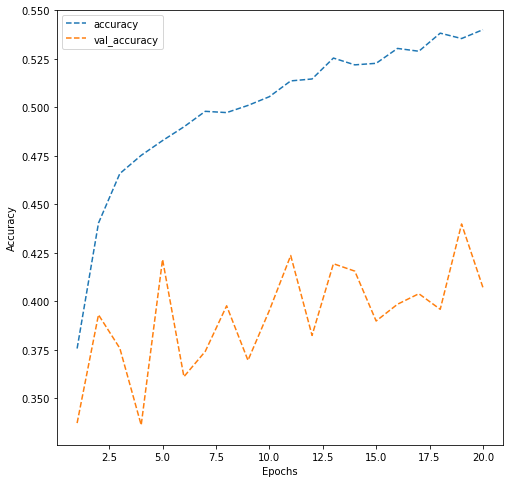

In [ ]:
# Plotting the accuracies

dict_hist = history.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

### **Evaluating the VGG16 model**

In [ ]:
# Write your code to evaluate model performance on the test set
accuracy = vggmodel.evaluate(test_set, verbose = 2)

4/4 - 3s - loss: 1.2740 - accuracy: 0.3906 - 3s/epoch - 820ms/step


**Observations and Insights:**
* Training accuracy continues to improve with increasing epochs. Validation accuracy fluctutes heavily with increasing epochs and generally increases only till the 10 epoch where it fluctuates about the same value ~40%. 
* After 20 epochs, the training accuracy is 54%, validation accuracy is 40% and test accuracy is ~39%. A much higher training accuracy suggests some overfitting.
*	The model gave very poor results on the validation and test accuracies which also suggests underfitting, the validation accuracy also showed large fluctuations over 20 epochs, this shows that the model is not stable and not performing well.
* The fact that model performance did not improve considerably as the epoch increased is an indication that the algorithm was learning very slowly as the epochs increased or the model was stuck in a local minima. We can try to improve this by tuning some hyperparameters like increasing the learning rate, changing the activation function, using more filters, adding more batch normalization layers.
* Hyperparameter tuning can help but is exhaustive and can take a long time to find the right set of values for each hyperparameter. A more practical solution could be to add another CNN architecture on top of the vgg layer to learn more features.
* Model performance very poor and cannot be used. There are other pre-trained models which can be tried and/or tuned to get better performance.



## **ResNet V2 Model**

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import tensorflow as tf
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model

Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                          

### **Model Building**

* In this model, we will import till the **'conv5_block3_add'** layer of the ResNet model. You can scroll down in the model summary and look for 'conv5_block3_add'. You can choose any other layer as well.
* Then we will add a Flatten layer, which receives the output of the 'conv5_block3_add' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* You may use Dropout and BatchNormalization layers as well.
* Then we will add our last dense layer, which must have 4 neurons and a 'softmax' activation function.

In [ ]:
transfer_layer_Resnet = Resnet.get_layer('conv5_block3_add')
Resnet.trainable=False

# Add classification layers on top of it

# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer_Resnet.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

resnetmodel = Model(Resnet.input, pred) # Initializing the model

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Resnetmodel.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )                    


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 10

In [ ]:
# Write your code to compile your resnetmodel. Use categorical crossentropy as your loss function, Adam Optimizer with 0.001 learning rate, and set your metrics to 'accuracy'. 
resnetmodel.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.
history = resnetmodel.fit(train_set, validation_data = validation_set, epochs = 20)


Epoch 1/20
473/473 [==============================] - 346s 717ms/step - loss: 1.4635 - accuracy: 0.2611 - val_loss: 1.4299 - val_accuracy: 0.1601
Epoch 2/20
473/473 [==============================] - 341s 722ms/step - loss: 1.4036 - accuracy: 0.2636 - val_loss: 1.3763 - val_accuracy: 0.2289
Epoch 3/20
473/473 [==============================] - 339s 716ms/step - loss: 1.4003 - accuracy: 0.2562 - val_loss: 1.3579 - val_accuracy: 0.3667
Epoch 4/20
473/473 [==============================] - 344s 728ms/step - loss: 1.3959 - accuracy: 0.2606 - val_loss: 1.3897 - val_accuracy: 0.2289
Epoch 5/20
473/473 [==============================] - 342s 723ms/step - loss: 1.3957 - accuracy: 0.2638 - val_loss: 1.3645 - val_accuracy: 0.3667
Epoch 6/20
473/473 [==============================] - 341s 721ms/step - loss: 1.3927 - accuracy: 0.2607 - val_loss: 1.3668 - val_accuracy: 0.3667
Epoch 7/20
473/473 [==============================] - 341s 722ms/step - loss: 1.3918 - accuracy: 0.2652 - val_loss: 1.3767 -

### **Evaluating the ResNet Model**

In [ ]:
# Write your code to evaluate model performance on the test set
accuracy = resnetmodel.evaluate(test_set, verbose = 2)

4/4 - 2s - loss: 1.3901 - accuracy: 0.2500 - 2s/epoch - 535ms/step


**Observations and Insights:**
* Training accuracy very low at ~26% and does not improve with increasing epochs. Validation accuracy increases only up to the 3rd epoch and then fluctutes heavily between the values "22%-35%" until the 20th epoch.
* After 20 epochs, the training accuracy remains at 26%, validation accuracy is 35% and test accuracy is ~25%. A lower training accuracy indicates high training error and high bais of the model.
* The model gave very poor results on the validation and test accuracies which also suggests **underfitting**, the validation accuracy also showed large fluctuations over 20 epochs, this shows that the model is not stable and not performing well.
* The fact that model performance did not improve is an indication that the algorithm wasnt learning as the epochs increased or the model was stuck in a local minima. We can try to improve this by tuning some hyperparameters like increasing the learning rate,changing the activation function, using more filters, adding more batch normalization layers. 
* Hyperparameter tuning can help but is exhaustive and can take a long time to find the right set of values for each hyperparameter. A more practical solution could be to add another CNN architecture on top of the resnet layer to learn more features.
* Model performance very poor and cannot be used. There are other pre-trained models which can be tried and/or tuned to get better performance.



## **EfficientNet Model**

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import tensorflow as tf
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
EfficientNet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))

EfficientNet.summary()

35848192/35839040 [==============================] - 1s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                 

### **Model Building**

In [ ]:
transfer_layer_EfficientNet = EfficientNet.get_layer('block6e_expand_activation')
EfficientNet.trainable = False

# Add your Flatten layer.
x = Flatten()(transfer_layer_EfficientNet.output)

# Adding a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)


Efficientnetmodel = Model(EfficientNet.input, pred)

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Efficientnetmodel.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 10

In [ ]:
# Write your code to compile your Efficientnetmodel. Use categorical crossentropy as your loss function, Adam Optimizer with 0.001 learning rate, and set your metrics to 'accuracy'.
Efficientnetmodel.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.
history = Efficientnetmodel.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 [==============================] - 101s 202ms/step - loss: 1.4524 - accuracy: 0.2598 - val_loss: 1.3761 - val_accuracy: 0.2289
Epoch 2/20
473/473 [==============================] - 93s 197ms/step - loss: 1.4046 - accuracy: 0.2602 - val_loss: 1.3635 - val_accuracy: 0.2443
Epoch 3/20
473/473 [==============================] - 94s 199ms/step - loss: 1.3973 - accuracy: 0.2583 - val_loss: 1.3636 - val_accuracy: 0.2417
Epoch 4/20
473/473 [==============================] - 95s 200ms/step - loss: 1.3945 - accuracy: 0.2583 - val_loss: 1.3692 - val_accuracy: 0.2289
Epoch 5/20
473/473 [==============================] - 96s 203ms/step - loss: 1.3920 - accuracy: 0.2549 - val_loss: 1.3484 - val_accuracy: 0.3667
Epoch 6/20
473/473 [==============================] - 94s 199ms/step - loss: 1.3909 - accuracy: 0.2567 - val_loss: 1.3674 - val_accuracy: 0.2443
Epoch 7/20
473/473 [==============================] - 97s 204ms/step - loss: 1.3896 - accuracy: 0.2638 - val_loss: 1.3631 - val_a

### **Evaluating the EfficientnetNet Model**

In [ ]:
# Write your code to evaluate the model performance on the test set
accuracy = Efficientnetmodel.evaluate(test_set, verbose = 2)

4/4 - 1s - loss: 1.3910 - accuracy: 0.2500 - 595ms/epoch - 149ms/step


**Observations and Insights:**
* Training accuracy very low at ~26% and did not improve with increasing epochs. Validation accuracy fluctutes heavily between the values "22%-35%" until the 20th epoch.
* After 20 epochs, the training accuracy remains at 26%, validation accuracy is 37% and test accuracy is ~25%. A lower training accuracy indicates high training error and high bais of the model.
* The model gave very poor results on the validation and test accuracies which also suggests underfitting, the validation accuracy also showed large fluctuations over 20 epochs, this shows that the model is not stable and not performing well.
* The fact that model performance did not improve is an indication that the algorithm wasnt learning as the epochs increased or the model was stuck in a local minima. We can try to improve this by tuning some hyperparameters like increasing the learning rate,changing the activation function, using more filters, adding more batch normalization layers.
* Hyperparameter tuning can help but is exhaustive and can take a long time to find the right set of values for each hyperparameter. A more practical solution could be to add another CNN architecture on top of the Efficientnet layer to learn more features.
* Model performance very poor and cannot be used. There are other pre-trained models which can be tried and/or tuned to get better performance.



**Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.**

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [ ]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)


datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

validation_set = datagen_train.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = "grayscale" ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)
test_set = datagen_train.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = "grayscale" ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

* In this network, we plan to have 5 Convolutional Blocks
* Add first Conv2D layer with **64 filters** and a **kernel size of 2**. Use the 'same' padding and provide the **input shape = (48, 48, 1)**. Use **'relu' activation**.
* Add a BatchNormalization layer followed by a LeakyRelU layer with Leaky ReLU parameter of **0.1**
* Add MaxPooling2D layer with **pool size = 2**.
* Add a Dropout layer with a Dropout Ratio of **0.2**. This completes the first Convolutional block.
* Add a second Conv2D layer with **128 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.**
* Follow this up with a similar BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer like above to complete your second Convolutional Block.
* Add a third Conv2D layer with **512 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.** Once again, follow it up with a BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer to complete your third Convolutional block.
* Add a fourth block, with the Conv2D layer having **512 filters**.
* Add the fifth block, having **128 filters**.
* Then add a Flatten layer, followed by Dense layers.
* Add first Dense layer with **256 neurons** followed by a BatchNormalization layer, a **'relu'** Activation, and a Dropout layer. This forms your first Fully Connected block
* Add the second Dense layer with **512 neurons**, again followed by a BatchNormalization layer, **relu** activation, and a Dropout layer.
* Add the final Dense layer with 4 neurons.
* Compile model with the optimizer.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import tensorflow as tf
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [ ]:
no_of_classes = 4

model3 = Sequential()

# Add 1st CNN Block
model3.add(Conv2D(64, (2, 2), activation = 'relu',  padding = "same", input_shape = (48, 48, 1)))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

# Add 2nd CNN Block
model3.add(Conv2D(128, (2, 2), activation = 'relu',  padding = "same"))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

# Add 3rd CNN Block
model3.add(Conv2D(512, (2, 2), activation = 'relu',  padding = "same"))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

# Add 4th CNN Block
model3.add(Conv2D(512, (2, 2)))

# Add 5th CNN Block
model3.add(Conv2D(128, (2, 2)))

model3.add(Flatten())

# First fully connected layer
model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.2))

# Second fully connected layer
model3.add(Dense(512))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.2))

model3.add(Dense(no_of_classes, activation = 'softmax'))

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        320       
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

epochs = 35

steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model3.h5", monitor = 'val_accuracy',
                            save_weights_only = True, model = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0001 , model = 'auto')

callbacks = [checkpoint, reduce_lr]

In [ ]:
# Write your code to compile your model3. Use categorical crossentropy as the loss function, Adam Optimizer with 0.003 learning rate, and set metrics to 'accuracy'.
model3.compile(optimizer = Adam(learning_rate = 0.003), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model3.fit(train_set, validation_data = validation_set, epochs = 35) # Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train your model for 35 epochs.

Epoch 1/35
473/473 [==============================] - 327s 689ms/step - loss: 1.3937 - accuracy: 0.3543 - val_loss: 1.3477 - val_accuracy: 0.2797
Epoch 2/35
473/473 [==============================] - 324s 685ms/step - loss: 1.1899 - accuracy: 0.4699 - val_loss: 1.2959 - val_accuracy: 0.3605
Epoch 3/35
473/473 [==============================] - 322s 681ms/step - loss: 1.0772 - accuracy: 0.5245 - val_loss: 1.2316 - val_accuracy: 0.4394
Epoch 4/35
473/473 [==============================] - 323s 682ms/step - loss: 1.0124 - accuracy: 0.5565 - val_loss: 1.3203 - val_accuracy: 0.4023
Epoch 5/35
473/473 [==============================] - 322s 680ms/step - loss: 0.9773 - accuracy: 0.5724 - val_loss: 1.0735 - val_accuracy: 0.4728
Epoch 6/35
473/473 [==============================] - 321s 680ms/step - loss: 0.9373 - accuracy: 0.5984 - val_loss: 1.0546 - val_accuracy: 0.5033
Epoch 7/35
473/473 [==============================] - 323s 682ms/step - loss: 0.9161 - accuracy: 0.6082 - val_loss: 1.1017 -

### **Evaluating the Model on Test Set**

In [ ]:
# Write your code to evaluate the model performance on the test set
accuracy = model3.evaluate(test_set, verbose = 2)

4/4 - 1s - loss: 1.0585 - accuracy: 0.5234 - 629ms/epoch - 157ms/step


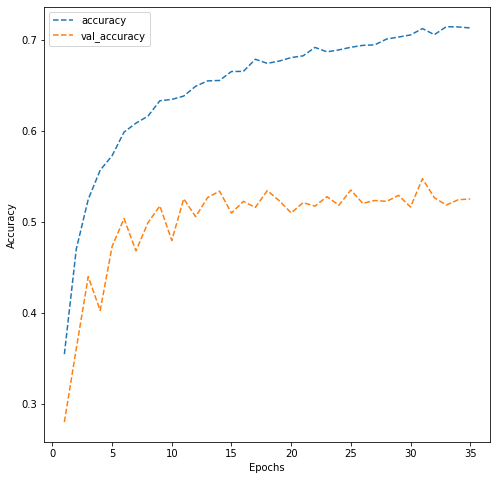

In [ ]:
# Plotting the accuracies

dict_hist = history.history

list_ep = [i for i in range(1, 36)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

**Observations and Insights:**
* Both training and validation accuracies are displaying and upward trend against the number of epochs.
* After 20 epochs, the training accuracy is 71% and validation accuracy is 52%, test accuracy is 52%. The model accuracy has improved significantly compared to previous models.
* Changing the color mode to 'greyscale' seems to have a positive effect in the performance of the model.
* Much higher accuracy on the training set suggests significant overfitting of the model. 
* The model gave poor results on the validation and test accuracies which also suggests underfitting, the validation accuracy also showed fluctuations over 20 epochs, this shows that the model is not stable and not performing well.
* Model performance is poor on validation and test sets and model cannot be used.
* The model performance can be further improved by implementing generalisation techniques to solve overfitting problem like increasing the (dropout rate and batchsize). We can try out a few iterations to further improve model performance like increasing number of filters, using a different activation function or optimizer, adding more convolution and dense layers, and increasing the number of epochs.


### **Plotting the Confusion Matrix for the chosen final model**

Found 128 images belonging to 4 classes.
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        32
           1       0.66      0.78      0.71        32
           2       0.67      0.75      0.71        32
           3       0.96      0.84      0.90        32

    accuracy                           0.77       128
   macro avg       0.79      0.77      0.78       128
weighted avg       0.79      0.77      0.78       128



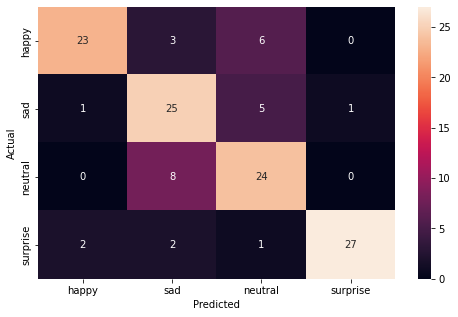

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True) 
test_images, test_labels = next(test_set)

# Write the name of your chosen model in the blank
pred = model3.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:**
* The model is majorly confused between the following emotions, 'happy and neutral' and 'sad and neutral'. These 3 emotions (i.e happy, sad, neutral) also have the lowest recall values.
* Surprise has the highest f1-score. 
* 'sad and neutral' are the most mis-classified while 'surprise & neutral' is the least mis-classified.
* Overall the model is performing poorly on test data with accuracy of 77%. * The recall has a range of values between 72% for 'happy' images and 84% for 'surprise',  which implies that the model is best at identifying 'surprise' images and worst at identifying 'happy' images. 
* Consequently, 'sad' class having the least precision which implies the model having most difficultly distinguishing from other emotions, this could be due to the fact that 'sad' and 'nertral' expressions seem to have very similar facial characteristics.
* The highest precision is for 'surprise' which implies that the model can distinguish 'surprise' from other images.
* We can still try to add more layers to see if we can bring down the misclassification further

## **Conclusion**

* This aim of this project is to find the most efficient Deep Learning architecture that can classify images of facial expressions into 4 classes namely 'happy', 'sad', 'neutral', 'surprise'.
* By efficiency, we are not only talking about accuracy. We are also talking about computation time because when this model will be implemented in the real world, we would expect it to be super fast, besides being super accurate.
* Some images from two or more classes have a lot of similarities between them. We expect our neural network to learn from their subtle differences to correctly classify the images.
* We implemented transfer learning for the first 3 models and the first model we created was the VGG16 pre-trained model. We observed that the model perfomed poorly on the data at hand with test accuracy of ~40%. The possible reasons could be that the hyperparameters required further tuning, the model needed to run for more epochs, we used 'rgb' color mode instead of 'greyscale' since the images are in almost in black and white .
* The 2nd model we created a ResNet V2 pre-trained model. We observed that the model perfomed poorly on the data at hand with test accuracy of ~25%. The possible reasons were that the hyperparameters required further tuning, the model needed to run for more epochs, we used 'rgb' color mode instead of 'greyscale' since the images are in almost in black and white.
* The 3rd model we created a EfficientNet pre-trained model. We observed that the model perfomed poorly on the data at hand with test accuracy of ~25%. The possible reasons were that the hyperparameters required further tuning, the model needed to run for more epochs, we used 'rgb' color mode instead of 'greyscale' since the images are in almost in black and white.
* The 4th model we created a complex CNN model with greyscale input. We observed that the model perfomed much better than the previous models on the data at hand with validation accuracy of ~72% and test accuracy of ~52%. 
* It is overfitting on training data. We can using more regularization techniques like adding more dropout layers and data augmentation to reduce overfitting.
* The 4th model with 1 ‘greyscale’ input channel performed significantly better on the data set and this might be due to the fact that the images are almost in black & white with inherent grey pixels.
* The 4th model is our best performing model and should be adopted. But the model is still underperforming and will have to improve significantly before it can be used in the real world.To get better performance, we can try to add more convolutional filters, more convolutional and dense layers, increasing number of epochs. 
* However, adding more nodes, parameters, epochs also increases the time required to fit the model and this may bring down its efficiency in the real world, hence there is a trade-off. In such a case, **batch normalization** comes in handy. It can speed up the training process.







